# Temperature - Variance Ablation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

### Temperature Plots: Temperature (x) v. Variance of I.S. Samples

In [43]:
paths = sorted(glob.glob("../data/importance_sampling/shakespeare/temp_ablation/*.pkl"))
temps = sorted([float(path.split("_")[-2].replace('t','').replace("z",'')) for path in sorted(paths)])

In [70]:
# (samples,vocab)
paths = sorted(glob.glob("../data/importance_sampling/shakespeare/temp_ablation/*.pkl"))
temps = sorted([float(path.split("_")[-2].replace('t','')) for path in sorted(paths)])

variances = []; entropies = []; estimates = []
for pth,temp in zip(paths,temps):
    data = read_pkl(pth)
    samples = data['sample_estimates']
    excluded_terms = data['excluded_terms']
    expanded_excluded_terms = torch.LongTensor(excluded_terms).repeat((samples.shape[1],1)).T.unsqueeze(-1)
    samples = torch.gather(samples,-1,
                           expanded_excluded_terms).squeeze()
    var = torch.var(samples,dim=-1)
    entropy= -(data['q_log_prob'].squeeze()+1e-10).mean(dim=-1)
    estimates.append(samples.mean(dim=-1))
    variances.append(var)
    entropies.append(entropy)
    # break
    
# variances = torch.cat(variances)
# entropies = torch.cat(entropies)

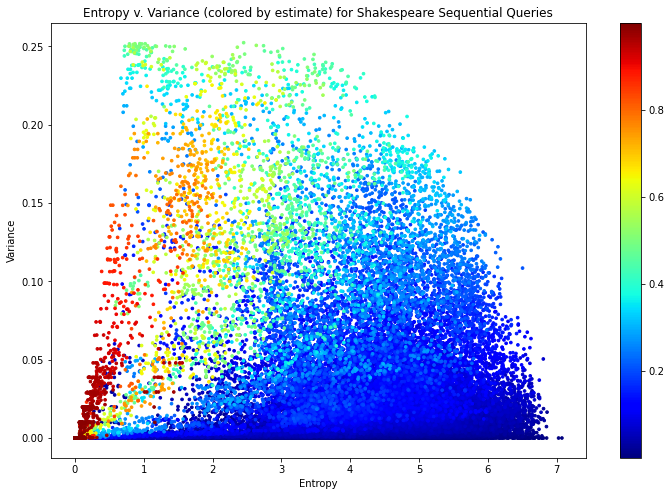

In [91]:
plt.figure(figsize=(12,8))
x = torch.cat(entropies)
y = torch.cat(variances)
color = torch.cat(estimates)
color,inds = torch.sort(color,descending=False)
x = x[inds]
y = y[inds]
plt.scatter(x, y, s=7,
            c=color, cmap=plt.cm.jet)
plt.xlabel("Entropy")
plt.ylabel("Variance")
plt.title("Entropy v. Variance (colored by estimate) for Shakespeare Sequential Queries")
plt.colorbar()

<AxesSubplot:>

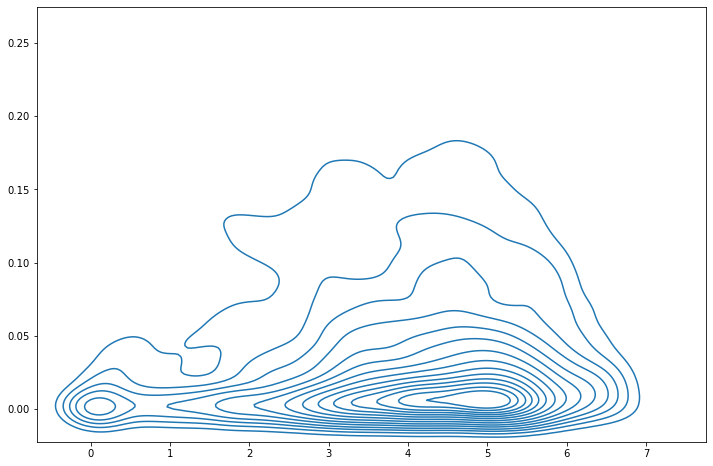

In [69]:
plt.figure(figsize=(12,8))
x = torch.cat(entropies)
y = torch.cat(variances)
sns.kdeplot(
    x=x, y=y,
    levels=15
)

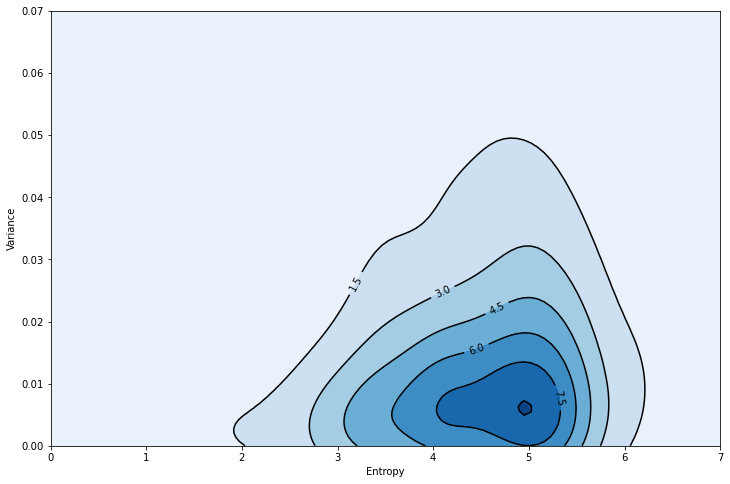

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

x = torch.cat(entropies)
y = torch.cat(variances)
xmin, xmax = 0, 7
ymin, ymax = 0, 0.07

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize = (12,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_ylabel('Variance')
ax.set_xlabel('Entropy')

plt.show()

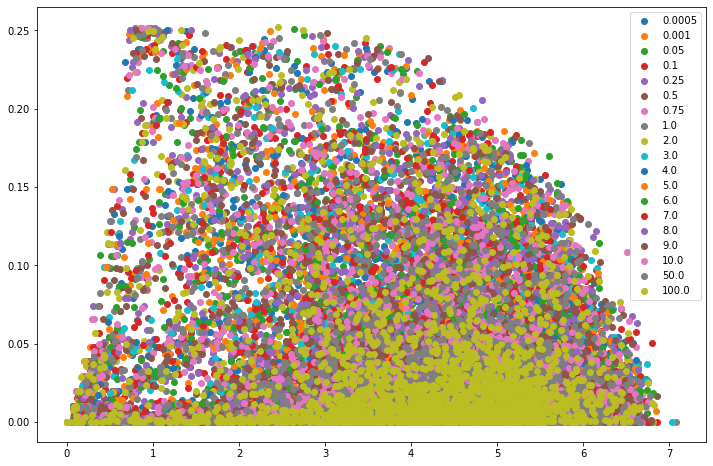

In [57]:
plt.figure(figsize=(12,8))
for i in range(len(temps)):
    plt.scatter(entropies[i],variances[i],label =temps[i])
plt.legend()

In [58]:
paths

['../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampling_17h_20s_0.0005t_exc-dynamic.pkl',
 '../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampling_17h_20s_0.001t_exc-dynamic.pkl',
 '../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampling_17h_20s_0.05t_exc-dynamic.pkl',
 '../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampling_17h_20s_0.1t_exc-dynamic.pkl',
 '../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampling_17h_20s_0.25t_exc-dynamic.pkl',
 '../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampling_17h_20s_0.5t_exc-dynamic.pkl',
 '../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampling_17h_20s_0.75t_exc-dynamic.pkl',
 '../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampling_17h_20s_001t_exc-dynamic.pkl',
 '../data/importance_sampling/shakespeare/temp_ablation/val-dl_importance-sampli

In [59]:
test_data = data_tensor
test_data.shape

(19, 2287)

In [74]:
df = pd.DataFrame(test_data.T)
df.columns = [temps]
# df.loc[:,1.0].head()
# reldf = df/(df[1.0] + 1e-5)
df = pd.melt(pd.DataFrame(test_data.T), value_vars = list(range(len(paths))))
df.shape

(43453, 2)

## Sequence Length: 10, 50 samples

In [71]:
df.value += 1e-5
df['value'] = np.log(df.value)
# df['value'] = np.log(df.value + 1e-2)
df.head()
df.shape

(43453, 2)

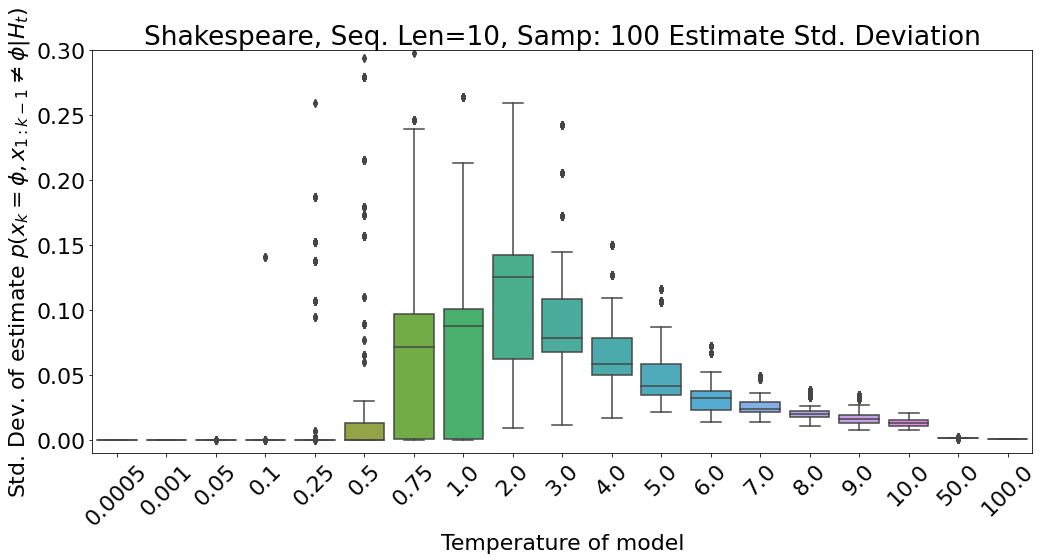

In [78]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=df.variable, y=df.value,whis = 1.5)
ax.set_xticklabels(temps)
plt.xlabel("Temperature of model")
plt.ylabel(r"Std. Dev. of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
plt.title("Shakespeare, Seq. Len=10, Samp: 100 Estimate Std. Deviation")
plt.xticks(rotation=45)
plt.ylim(-0.01,0.3)
plt.tight_layout()

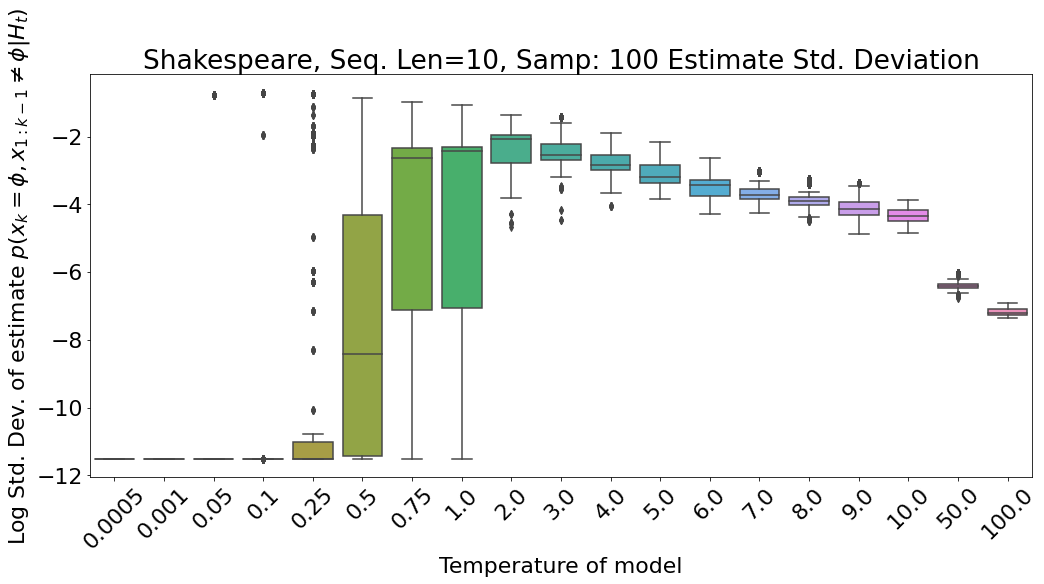

In [73]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=df.variable, y=df.value,whis = 1.5)
ax.set_xticklabels(temps)
plt.xlabel("Temperature of model")
plt.ylabel(r"Log Std. Dev. of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
plt.title("Shakespeare, Seq. Len=10, Samp: 100 Estimate Std. Deviation")
plt.xticks(rotation=45)
plt.tight_layout()

## Sequence Length: 15, 100 samples

In [47]:
df.value += 1e-5
df['value'] = np.log(df.value)
# df['value'] = np.log(df.value + 1e-2)
df.head()
# df.shape

,variable,value
0,0,-11.512925
1,0,-11.512925
2,0,-11.512925
3,0,-11.512925
4,0,-11.512925


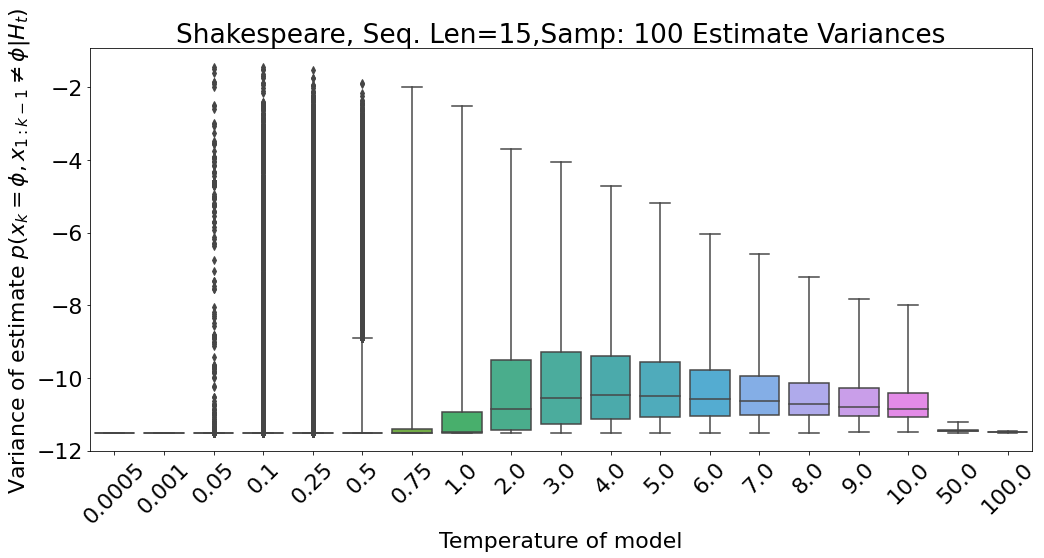

In [49]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=df.variable, y=df.value,whis = 10000.0)
ax.set_xticklabels(temps)
plt.xlabel("Temperature of model")
plt.ylabel(r"Variance of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
plt.title("Shakespeare, Seq. Len=15,Samp: 100 Estimate Variances")
plt.xticks(rotation=45)
plt.tight_layout()

## Sequence Length: 5, 100 samples

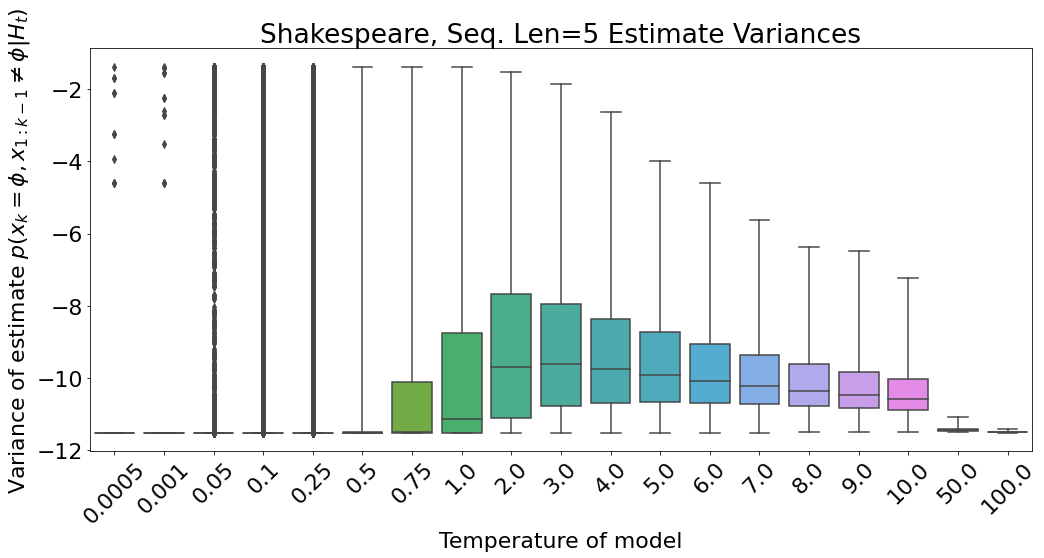

In [33]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=df.variable, y=df.value,whis = 10000.0)
ax.set_xticklabels(temps)
plt.xlabel("Temperature of model")
plt.ylabel(r"Variance of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
plt.title("Shakespeare, Seq. Len=5, Samp: 100 Estimate Variances")
plt.xticks(rotation=45)
plt.tight_layout()

## Sequence Length: 10, 1000 samples

In [7]:
df.value += 1e-5
df['value'] = np.log(df.value)
# df['value'] = np.log(df.value + 1e-2)
df.head()
# df.shape

,variable,value
0,0,-11.512925
1,0,-11.512925
2,0,-11.512925
3,0,-11.512925
4,0,-11.512925


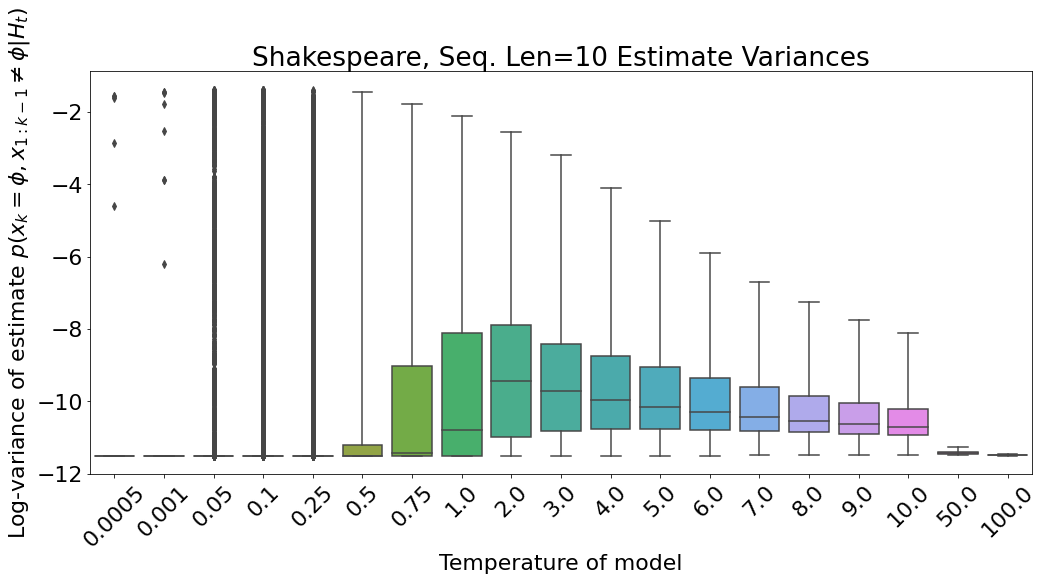

In [9]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=df.variable, y=df.value,whis = 10000.0)
ax.set_xticklabels(temps)
plt.xlabel("Temperature of model")
plt.ylabel(r"Log-variance of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
plt.title("Shakespeare, Seq. Len=10, Samp 100 Estimate Variances")
plt.xticks(rotation=45)
plt.tight_layout()

## Sequence Length: 2

In [11]:
df.value += 1e-5
df['value'] = np.log(df.value)
# df['value'] = np.log(df.value + 1e-2)
df.head()
# df.shape

,variable,value
0,0,-11.512925
1,0,-11.512925
2,0,-11.512925
3,0,-11.512925
4,0,-11.512925


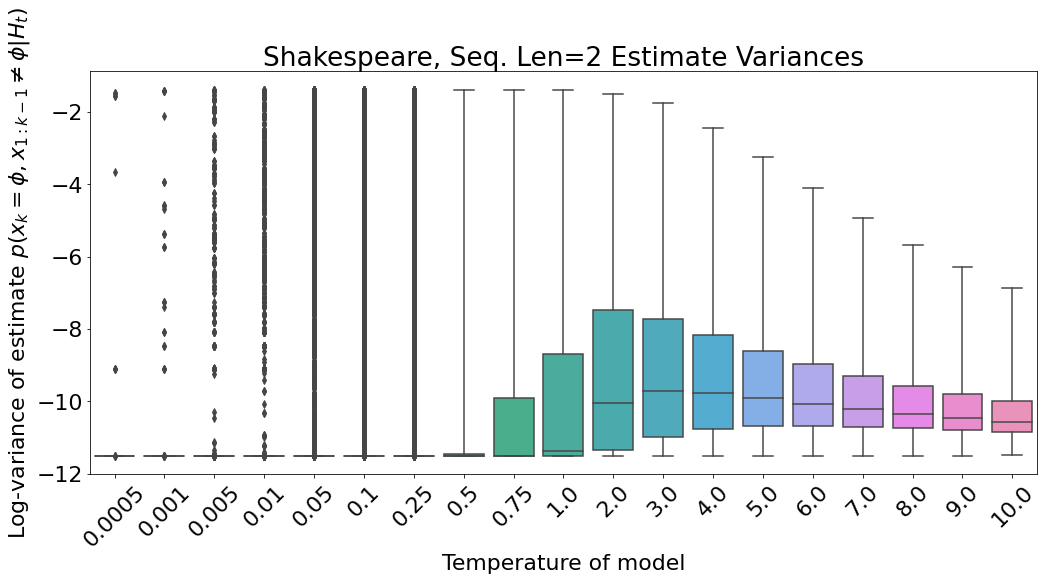

In [20]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(x=df.variable, y=df.value,whis = 10000.0)
ax.set_xticklabels(temps)
plt.xlabel("Temperature of model")
plt.ylabel(r"Log-variance of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
plt.title("Shakespeare, Seq. Len=2, Samp: 1000 Estimate Variances")
plt.xticks(rotation=45)
plt.tight_layout()

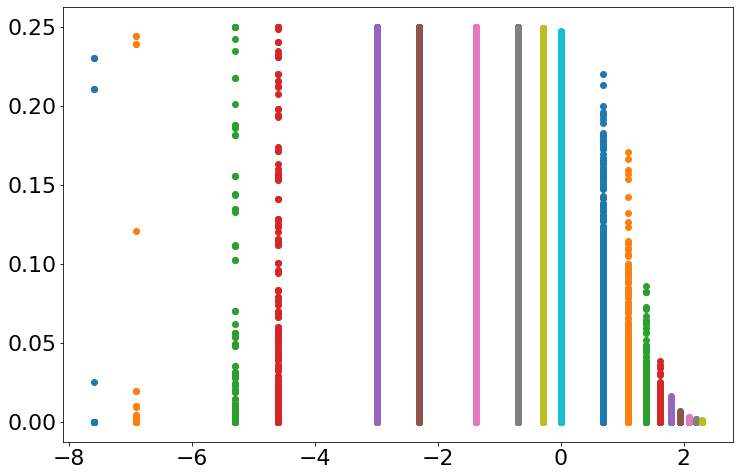

In [14]:
fig = plt.subplots(figsize = (12,8))
for i,temp in enumerate(temps):
    plt.scatter(torch.ones(data_tensor.shape[-1])*np.log(temp),data_tensor[i])
# plt.boxplot(data_tensor)
plt.show()

dict_keys([0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100])
tensor(0.2525)
tensor(0.2525)
tensor(0.2525)
tensor(0.2521)
tensor(0.2307)
tensor(0.1849)
tensor(0.1173)
tensor(0.0235)
tensor(0.0025)
tensor(0.0002)
tensor(9.8397e-06)
tensor(7.6081e-07)
tensor(8.9884e-08)
tensor(1.4666e-08)
tensor(3.1315e-09)
tensor(8.3238e-10)
tensor(2.0202e-15)
tensor(1.6991e-16)


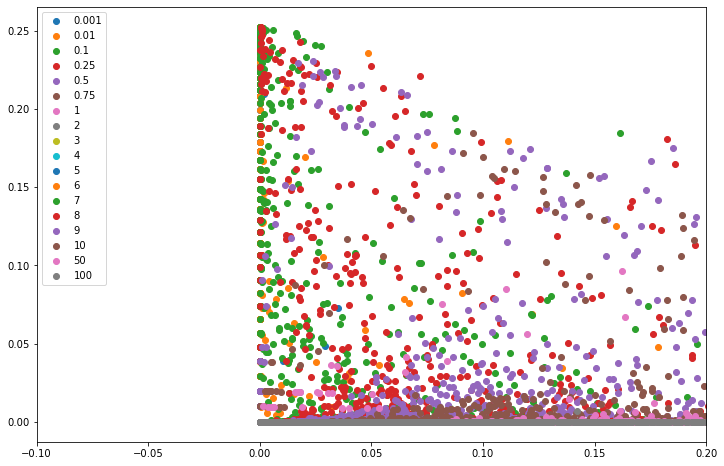

In [13]:
fig = plt.subplots(figsize = (12,8))
data = read_pkl("../notebooks/entropy_test_samples.pkl")
print(data.keys())
for t in data:
    tdict = data[t]
    # print(tdict['entropy'].mean())
    print(tdict['variance'].max())
    plt.scatter(tdict['entropy'],tdict['variance'], label = t)
    
plt.xlim(-0.1,0.20)
plt.legend()